### IMPORT LIBRARIES

In [659]:
#load the data and import the necessary libraries
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import warnings
import itertools
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix,precision_recall_curve,roc_curve, auc 
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,RepeatedStratifiedKFold
from IPython.display import Image  
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from functions import confusion,class_imbalance,smote_class,plot_feature_importances,evaluation_metrics,feature_engine
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### EXPLORATORY DATA ANALYSIS

In [21]:
transactions = pd.read_csv("transactions_data.csv")

In [22]:
customers = pd.read_csv("customer_data.csv")

In [23]:
transactions.head() #print out the first five rows for both datasets

,Transaction ID,Customer ID,Date,Total Items,Unique Items,Total Sales,Discounted Sales,Browsing Duration (minutes),Number of Clicks,Incomplete Transaction
0,TRID_21210,CID_12160,2020-03-22,8,3,22.88,7.54,3.11,7,0
1,TRID_83725,CID_11410,2020-01-08,4,2,22.80,4.79,7.51,15,0
2,TRID_10532,CID_12776,2020-02-19,5,3,14.80,7.96,8.98,16,0
3,TRID_88885,CID_9162,2020-02-17,5,3,13.04,6.98,5.61,11,0
4,TRID_68790,CID_14594,2020-01-06,14,4,9.60,9.25,6.62,14,1


In [24]:
customers.head()

,Customer ID,Age,Gender,Region,Marital Status,Education,Household Income,Loyalty Card,Loyalty Points
0,CID_7225,63,Female,Urban,Married,High School,68000.0,1,6.0
1,CID_10008,49,Male,Urban,Divorced,Graduate,62500.0,1,4.0
2,CID_6297,51,Female,Suburban,Widowed,Graduate,58500.0,0,NaN
3,CID_5520,77,Female,Urban,Widowed,Graduate,52000.0,1,19.0
4,CID_6454,28,Male,Suburban,Single,NaN,27500.0,0,NaN


Find the shape of the data for both dataset

In [25]:
transactions.shape #there are 5000 rows of data and 10 feature columns

(5000, 10)

In [26]:
customers.shape #there are 2407 rows and 9 feature columns

(2407, 9)

Check each of the dataset for null and duplicate values

In [27]:
transactions.duplicated().any() #there are no duplicated values in either of the dataset

False

In [28]:
customers.duplicated().any()

False

In [29]:
transactions.isna().any() #there are no null values in the transactions dataset

Transaction ID                 False
Customer ID                    False
Date                           False
Total Items                    False
Unique Items                   False
Total Sales                    False
Discounted Sales               False
Browsing Duration (minutes)    False
Number of Clicks               False
Incomplete Transaction         False
dtype: bool

In [30]:
customers.isna().any() #there are null values in the education and loyalty points feature column

Customer ID         False
Age                 False
Gender              False
Region              False
Marital Status      False
Education            True
Household Income    False
Loyalty Card        False
Loyalty Points       True
dtype: bool

#### RENAME TRANSACTION DATA COLUMNS

In [31]:
transactions.head()

,Transaction ID,Customer ID,Date,Total Items,Unique Items,Total Sales,Discounted Sales,Browsing Duration (minutes),Number of Clicks,Incomplete Transaction
0,TRID_21210,CID_12160,2020-03-22,8,3,22.88,7.54,3.11,7,0
1,TRID_83725,CID_11410,2020-01-08,4,2,22.80,4.79,7.51,15,0
2,TRID_10532,CID_12776,2020-02-19,5,3,14.80,7.96,8.98,16,0
3,TRID_88885,CID_9162,2020-02-17,5,3,13.04,6.98,5.61,11,0
4,TRID_68790,CID_14594,2020-01-06,14,4,9.60,9.25,6.62,14,1


In [32]:
transactions.info() #the date feature columns needs to be converted to datetime object.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction ID               5000 non-null   object 
 1   Customer ID                  5000 non-null   object 
 2   Date                         5000 non-null   object 
 3   Total Items                  5000 non-null   int64  
 4   Unique Items                 5000 non-null   int64  
 5   Total Sales                  5000 non-null   float64
 6   Discounted Sales             5000 non-null   float64
 7   Browsing Duration (minutes)  5000 non-null   float64
 8   Number of Clicks             5000 non-null   int64  
 9   Incomplete Transaction       5000 non-null   int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 390.8+ KB


**The incomplete transaction column is the target column that we are trying to predict whereby 0 is the completed transaction and 1 is the incomplete transaction**.

Renaming all columns and removing whitespaces

In [36]:
transactions = transactions.rename(columns={"Transaction ID": "transaction_id", "Customer ID": "customer_id",
                            "Date": "date", "Total Items": "total_items", "Unique Items": "unique_items",
                            "Total Sales": "total_sales", "Discounted Sales": "discounted_sales",
                            "Browsing Duration (minutes)": "browsing_duration",
                            "Number of Clicks": "number_of_clicks", "Incomplete Transaction": "target" })

In [40]:
transactions['date'] = pd.to_datetime(transactions['date']) #convert object to datetime object

In [46]:
#Number of unique transactions
transactions.transaction_id.nunique() #there are 5000 unique transactions in the data

5000

In [47]:
#Number of unique customers in the transactions data
transactions.customer_id.nunique() #there are 2096 unique customers in the transactiosn data.

2096

In [51]:
#Number of days for the data collection period is 90 days
max(transactions.date) - min(transactions.date) 

Timedelta('90 days 00:00:00')

#### RENAME CUSTOMER DATA COLUMNS

In [53]:
#Rename the customers data column...
customers = customers.rename(columns={"Customer ID": "customer_id",
                            "Age": "age", "Gender": "gender", "Region": "region",
                            "Marital Status": "marital_status", "Education": "education",
                            "Household Income": "household_income", "Loyalty Card":"loyalty_card",
                            "Loyalty Points": "loyalty_points"})

In [54]:
customers.head()

,customer_id,age,gender,region,marital_status,education,household_income,loyalty_card,loyalty_points
0,CID_7225,63,Female,Urban,Married,High School,68000.0,1,6.0
1,CID_10008,49,Male,Urban,Divorced,Graduate,62500.0,1,4.0
2,CID_6297,51,Female,Suburban,Widowed,Graduate,58500.0,0,NaN
3,CID_5520,77,Female,Urban,Widowed,Graduate,52000.0,1,19.0
4,CID_6454,28,Male,Suburban,Single,NaN,27500.0,0,NaN


#### MERGE THE TRANSACTIONS AND CUSTOMER DATA

In [72]:
retail = transactions.merge(customers, on = "customer_id")

### SUMMARY STATISTICS

In [82]:
retail.describe() #summary statistics for the feature columns

,total_items,unique_items,total_sales,discounted_sales,browsing_duration,number_of_clicks,target,age,household_income,loyalty_card,loyalty_points
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,2435.000000
mean,5.508200,3.016400,13.711920,7.069330,5.760234,11.622200,0.20000,47.652200,47157.100000,0.487000,17.243121
std,2.584815,1.007141,5.639713,1.947033,1.857751,3.379371,0.40004,17.422432,24303.324874,0.499881,11.723395
min,1.000000,0.000000,2.640000,0.750000,1.000000,4.000000,0.00000,18.000000,5500.000000,0.000000,0.000000
25%,4.000000,2.000000,9.680000,5.770000,4.500000,9.000000,0.00000,32.000000,26500.000000,0.000000,8.000000
50%,5.000000,3.000000,12.560000,7.080000,5.720000,11.000000,0.00000,48.000000,47000.000000,0.000000,16.000000
75%,7.000000,4.000000,16.560000,8.390000,7.040000,14.000000,0.00000,62.000000,68500.000000,1.000000,25.000000
max,20.000000,7.000000,46.560000,14.460000,11.860000,23.000000,1.00000,77.000000,89500.000000,1.000000,63.000000


**Based on the summary statistics**

1. Average number of items in customers' basket is 5.
2. Average number of unique items in customers' basket is 3.
3. Average total sales exepected price is 12.5.
4. Average discounted price after discounts and vouchers is 7.08.
5. Average time customers spent browsing on the website is 5.72 minutes.
6. Average number of clicks during browsing duration is 11 clicks.
7. Average age of customer on the platform is 48 years old, youngest is 18 and oldest is 62 years old.
8. Average household income for customers is 47000.
9. Average loyalty points is 16.



In [85]:
#correlation of the dataframe
retail.corr()

,total_items,unique_items,total_sales,discounted_sales,browsing_duration,number_of_clicks,target,age,household_income,loyalty_card,loyalty_points
total_items,1.000000,0.254371,0.123579,0.245349,0.005260,0.005794,0.170010,-0.026884,0.002335,-0.015244,0.020476
unique_items,0.254371,1.000000,0.228751,0.958241,-0.010173,-0.005115,-0.085597,-0.009217,0.002698,0.002808,0.011992
total_sales,0.123579,0.228751,1.000000,0.238597,-0.001794,-0.006255,0.100788,0.000708,0.016536,-0.009602,-0.000570
discounted_sales,0.245349,0.958241,0.238597,1.000000,-0.006825,-0.001484,-0.080109,-0.012457,0.006932,0.000237,0.008646
browsing_duration,0.005260,-0.010173,-0.001794,-0.006825,1.000000,0.965103,0.041244,0.009214,0.000990,-0.003138,-0.023833
number_of_clicks,0.005794,-0.005115,-0.006255,-0.001484,0.965103,1.000000,0.041402,0.010230,0.000063,-0.006283,-0.030398
target,0.170010,-0.085597,0.100788,-0.080109,0.041244,0.041402,1.000000,0.004299,0.015368,-0.008003,0.008598
age,-0.026884,-0.009217,0.000708,-0.012457,0.009214,0.010230,0.004299,1.000000,0.016879,0.037184,-0.050546
household_income,0.002335,0.002698,0.016536,0.006932,0.000990,0.000063,0.015368,0.016879,1.000000,0.037336,-0.022372
loyalty_card,-0.015244,0.002808,-0.009602,0.000237,-0.003138,-0.006283,-0.008003,0.037184,0.037336,1.000000,NaN


**1. From the correlation table it is clear to see that the unique_items feature has a strong positive correlation with the discounted sales feature with pearson correlation value of 0.958.**

**2. We can also decipher from the correlation table that the browsing duration has a strong positive correlation with the number of clicks features with pearson correlation value of 0.965.**


In [84]:
retail.education.unique() #there are four seperate categories, one is unknown

array(['High School', 'Graduate', nan, 'Post-Graduate'], dtype=object)

### FEATURE ENGINEERING

Using encoding missingness as a feature engineering technique. When a predictor is discrete in nature, missingness can be directly encoded into the predictor as if it were a naturally occurring category.

1. We are going to categorise the Nan values in the education feature column as unknown let our model decide how important the feature is in the prediction of the target variable.

2. Encode Nan values in the loyalty points feature column as 0, this points to the fact that customers without loyalty card cannot get loyalty points



In [91]:
values = {'education': 'unknown', 'loyalty_points': 0.0}
retail = retail.fillna(value=values)

In [92]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   transaction_id     5000 non-null   object        
 1   customer_id        5000 non-null   object        
 2   date               5000 non-null   datetime64[ns]
 3   total_items        5000 non-null   int64         
 4   unique_items       5000 non-null   int64         
 5   total_sales        5000 non-null   float64       
 6   discounted_sales   5000 non-null   float64       
 7   browsing_duration  5000 non-null   float64       
 8   number_of_clicks   5000 non-null   int64         
 9   target             5000 non-null   int64         
 10  age                5000 non-null   int64         
 11  gender             5000 non-null   object        
 12  region             5000 non-null   object        
 13  marital_status     5000 non-null   object        
 14  educatio

Extract a new feature column **'month'** the transactions take place between January and March 2020.

In [95]:
#extract month from datetime feature column.
retail['month'] = pd.DatetimeIndex(retail['date']).month

In [97]:
#create a savings column that takes the difference of how much a customer saved for every transaction
retail['savings'] = retail['total_sales'] - retail['discounted_sales']

In [123]:
#change values in the categorical feature columns month and Loyalty card
dic_1 = {1: 'January', 2: 'February', 3: 'March'}
dic_2 = {0: 'No', 1: 'Yes'}

retail.replace({"loyalty_card": dic_2}, inplace = True)

In [124]:
retail.replace({'month': dic_1}, inplace = True)

### STATISTICAL DISTRIBUTION OF THE DATA

**checking for the normality of the distributions of the continuous variables in the data.**

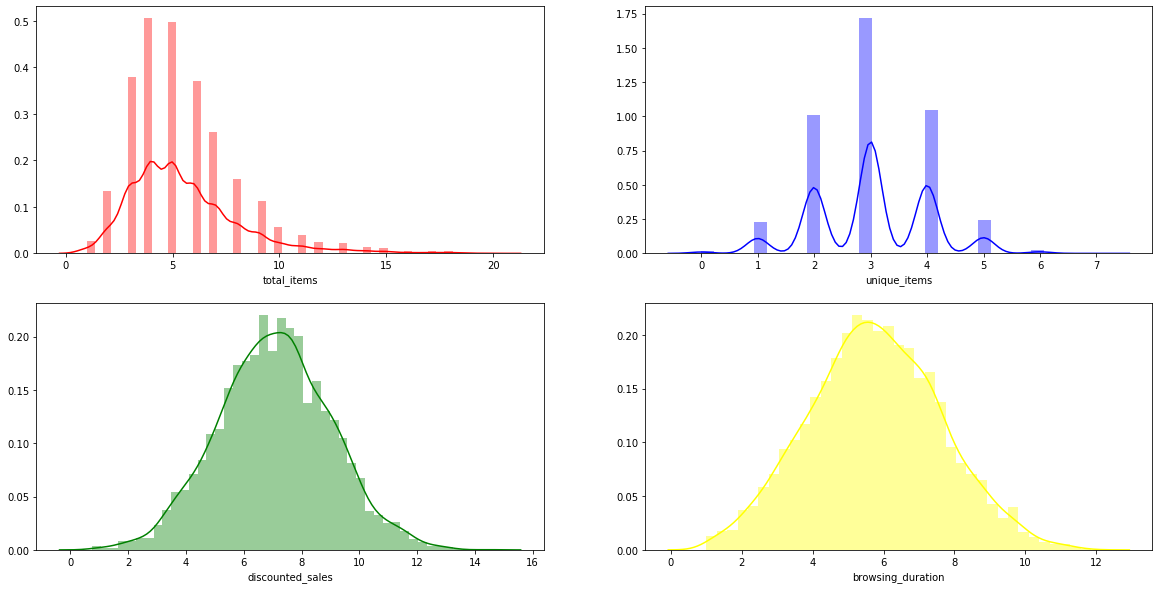

In [126]:
fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

sns.distplot(retail['total_items'], color = 'red', ax = ax1)
sns.distplot(retail['unique_items'], color = 'blue', ax = ax2)
sns.distplot(retail['discounted_sales'], color = 'green', ax = ax3)
sns.distplot(retail['browsing_duration'], color = 'yellow', ax = ax4);

Judging from the plot above, the discounted sales and browsing duration features do like normal(gaussian) distributions.

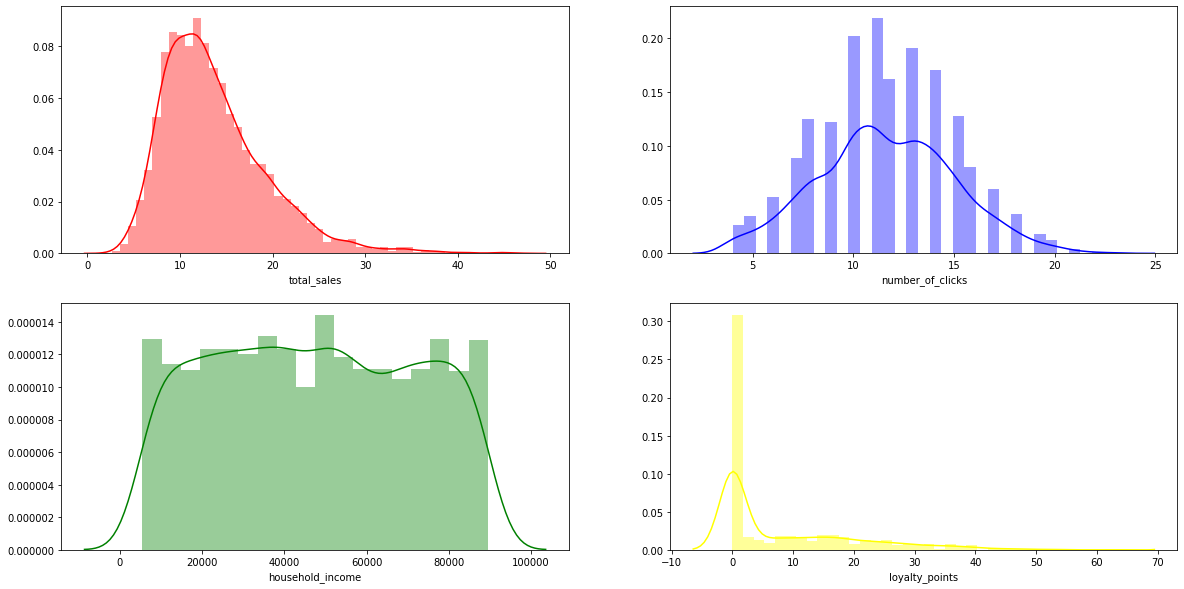

In [127]:
fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

sns.distplot(retail['total_sales'], color = 'red', ax = ax1)
sns.distplot(retail['number_of_clicks'], color = 'blue', ax = ax2)
sns.distplot(retail['household_income'], color = 'green', ax = ax3)
sns.distplot(retail['loyalty_points'], color = 'yellow', ax = ax4);

Total sales is a positively skewed distribution, this shows that most of the total sales is clustered around the left with a few outliers in the number of sales around the 40 and 50 mark.
The household income distribution resembles a uniform distribution, which describes an event where every possible outcome is equally likely. No single outcome carries any more or less probability of happening than any other possible outcome.

In [128]:
retail.corr() #pearson correlation table

,total_items,unique_items,total_sales,discounted_sales,browsing_duration,number_of_clicks,target,age,household_income,loyalty_points,savings
total_items,1.000000,0.254371,0.123579,0.245349,0.005260,0.005794,0.170010,-0.026884,0.002335,-0.001067,0.039792
unique_items,0.254371,1.000000,0.228751,0.958241,-0.010173,-0.005115,-0.085597,-0.009217,0.002698,0.007796,-0.104476
total_sales,0.123579,0.228751,1.000000,0.238597,-0.001794,-0.006255,0.100788,0.000708,0.016536,-0.007235,0.939272
discounted_sales,0.245349,0.958241,0.238597,1.000000,-0.006825,-0.001484,-0.080109,-0.012457,0.006932,0.004295,-0.109155
browsing_duration,0.005260,-0.010173,-0.001794,-0.006825,1.000000,0.965103,0.041244,0.009214,0.000990,-0.013761,0.000576
number_of_clicks,0.005794,-0.005115,-0.006255,-0.001484,0.965103,1.000000,0.041402,0.010230,0.000063,-0.019100,-0.005878
target,0.170010,-0.085597,0.100788,-0.080109,0.041244,0.041402,1.000000,0.004299,0.015368,-0.001700,0.131475
age,-0.026884,-0.009217,0.000708,-0.012457,0.009214,0.010230,0.004299,1.000000,0.016879,0.002836,0.005126
household_income,0.002335,0.002698,0.016536,0.006932,0.000990,0.000063,0.015368,0.016879,1.000000,0.016371,0.014476
loyalty_points,-0.001067,0.007796,-0.007235,0.004295,-0.013761,-0.019100,-0.001700,0.002836,0.016371,1.000000,-0.008924


### DATA PRE-PROCESSING

The baseline model is a logistic regression model and requires its features to have a numerical form, which means we have to encode the categorical features before using it in the model.
The most basic approach for achieving this is to create dummy/indicator variables; these are artificial numeric variables that capture the aspect of one or more of the categorical values.

#### CATEGORICAL/CONTINUOUS VARIABLE SEPERATION

In [182]:
#note that we have removed collinear features
retail_cat = retail[['month', 'loyalty_card', 'education', 'marital_status', 'region', 'gender']]
retail_cont = retail[['total_items', 'total_sales', 'discounted_sales',
                     'browsing_duration', 'age', 'household_income', 'loyalty_points']]
retail_target = retail['target']

The most simplistic feature engineering technique for a categorical predictor is to convert each category to a seperate binary dummy predictor using the get dummies method but as it can produce different transformed datasets because of rare levels not appearing in different samples of data. We are using the OneHot encoder for its consistency.

#### LOG-NORMALISATION OF CONTINUOUS DISTRBUTIONS

In [183]:
#Log normalisations for the distributions of the data
non_normal = ['total_items', 'total_sales', 'discounted_sales',
                     'browsing_duration', 'age', 'household_income', 'loyalty_points']
for feat in non_normal:
    retail_cont[feat] = retail_cont[feat].map(lambda x: np.log(x + 1))

### MACHINE LEARNING MODELING 

#### BASELINE LOGISTIC REGRESSION

In [199]:
predictors = pd.concat([retail_cont, retail_cat], axis = 1) #join both dataframes

In [200]:
#train,test,split the data with a 75/25 split
X_train, X_test, y_train, y_test = train_test_split(predictors,retail_target,test_size=0.25, random_state=42)

In [201]:
print(X_train.shape)
print(X_test.shape)

(3750, 13)
(1250, 13)


##### Seperate the categorical and continuous predictors for both X_train and X_test

In [211]:
cat_features = ['month', 'loyalty_card', 'education', 'marital_status', 'region', 'gender']
cont_features = ['total_items', 'total_sales', 'discounted_sales',
                     'browsing_duration', 'age', 'household_income', 'loyalty_points']

X_train_cont = X_train[cont_features]
X_train_cat = X_train[cat_features]
X_test_cont = X_test[cont_features]
X_test_cat = X_test[cat_features]

##### Standardizing and Categorical transformations

In [212]:
scaler = StandardScaler()

In [214]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_cont), columns = X_train_cont.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_cont), columns = X_test_cont.columns )

In [217]:
ohe = OneHotEncoder(handle_unknown='ignore')

In [219]:
X_train_ohe = ohe.fit_transform(X_train_cat)
X_test_ohe = ohe.transform(X_test_cat)

columns = ohe.get_feature_names(input_features=X_train_cat.columns)
cat_train_df = pd.DataFrame(X_train_ohe.todense(), columns=columns)
cat_test_df = pd.DataFrame(X_test_ohe.todense(), columns=columns)

##### Concatenate both test and train data

In [222]:
X_train_all = pd.concat([pd.DataFrame(X_train_scaled), cat_train_df], axis = 1)
X_test_all = pd.concat([pd.DataFrame(X_test_scaled), cat_test_df], axis = 1)

In [253]:
print("This is the number of complete and incomplete transactions in the train data")
print (y_train.value_counts())

print ('\n')

print("This is the number of complete and incomplete transactions in the test data")
print(y_test.value_counts())

This is the number of complete and incomplete transactions in the train data
0    2993
1     757
Name: target, dtype: int64


This is the number of complete and incomplete transactions in the test data
0    1007
1     243
Name: target, dtype: int64


Now that we have all train/test data and carried out the necessary data transformations, next step is to run a baseline logistic regression model.

In [225]:
logreg  = LogisticRegression(fit_intercept= False, C = 1e25, solver = 'liblinear', class_weight=None)
model_log = logreg.fit(X_train_all, y_train)
model_log

LogisticRegression(C=1e+25, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [229]:
y_hat_test = model_log.predict(X_test_all)
y_hat_train = model_log.predict(X_train_all)

The next step is to make use of the confusion matrix to check for the True Positives and the True Negatives of the predicted classes

In [395]:
# Print confusion matrix
cnf_matrix_lr = confusion_matrix(y_test,y_hat_test)
print('Confusion Matrix:\n', cnf_matrix_lr)

Confusion Matrix:
 [[1007    0]
 [ 241    2]]


##### Confusion matrix for baseline logistic regression

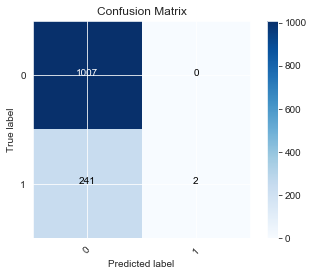

In [396]:
confusion(cnf_matrix_lr, retail_target)

Judging from the confusion matrix above, the logistic regression model accurately predicts the negative classes but performs woefully on the incomplete transactions data which we are more concerned about and we accurately want to predict. The prediction returns 241 False Negatives and 2 True positives for the incomplete transaction examples.
This might be attributed to class imbalance and will need rectifying if we want to optimise the model for recall/sensitivity.

##### Evaluation metrics for Baseline Logistic regression performance

In [595]:
evaluation_metrics(y_train,y_hat_train,y_test,y_hat_test)

Training Precision:  0.5625
Testing Precision:  1.0


Training Recall:  0.011889035667107
Testing Recall:  0.00823045267489712


Training Accuracy:  0.7986666666666666
Testing Accuracy:  0.8072


Training F1-Score:  0.02328589909443726
Testing F1-Score:  0.0163265306122449


Accuracy is the percentage of correct classifications over the total number of samples and since the model got all the complete transactions correctly, hence the high accuracy score of 80%.
Since precision is the ratio of correct positive predictions to the overall number of positive predictions, we have test score based on the high number of complete transactions predicted by the model.

We are interested in tuning our model performance for recall and get more of the incomplete transactions cases accurately predicted even though there will be more false positives(completed transaction cases inaccurately predicted as incomplete).

#### COST-SENSITIVE ACCURACY

Hypothetically speaking, if the cost of having a False negative prediction is 2 times more than having a false positive prediction from the model. We can compute cost-sensitive accuracy.

In [262]:
TN = 1007
TP = 2
FN = 241
FP = 0
cost_fn_fp = 2/1
cost_accuracy = (TP + TN)/(TP + TN + FP + (2*FN))

print(cost_accuracy) 

0.6767270288397049


Introducing a cost value for the false positives and false negative predictions decreases the accuracy of the model depending on our business goal.

#### ROC-CURVE

In [263]:
y_score = logreg.fit(X_train_all, y_train).decision_function(X_test_all)

fpr, tpr, thresholds = roc_curve(y_test, y_score)
print('AUC: {}'.format(auc(fpr, tpr))) #AUC Value of 0.571---which is slightly better than a AUC score of 0.5 for a random classifier

AUC: 0.571448420725702


##### ROC-CURVE PLOT

AUC: 0.571448420725702


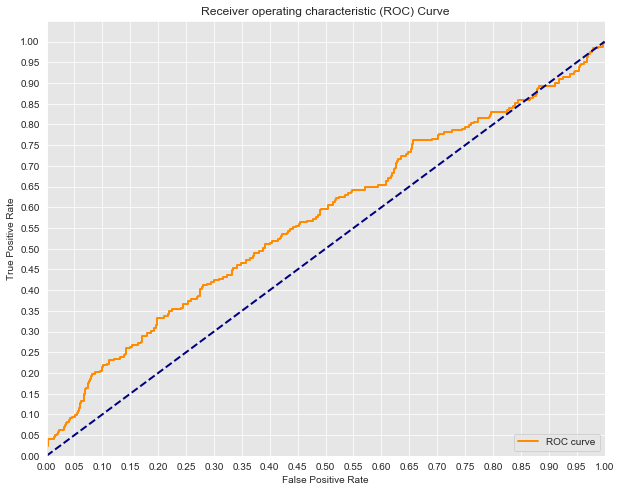

In [265]:
# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### CLASS-IMBALANCE

In [266]:
print('Normalized counts: \n')
print(retail['target'].value_counts(normalize=True))

Normalized counts: 

0    0.8
1    0.2
Name: target, dtype: float64


80% of the data is attributed to the complete online transactions and 20% is attributed to the incomplete online transactions. This means there is a massive imbalance in the dataset

##### USING WEIGHTING CLASS TO CHECK AGAINST CLASS IMBALANCE IN THE DATA

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for None: 0.5714443341057045
-------------------------------------------------------------------------------------
LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for Balanced: 0.5763319316226743
-------------------------------------------------------------------------------------
LogisticRegression(C=100, class_weight={0: 1, 1: 2}, dual=False,
                   fit_interc

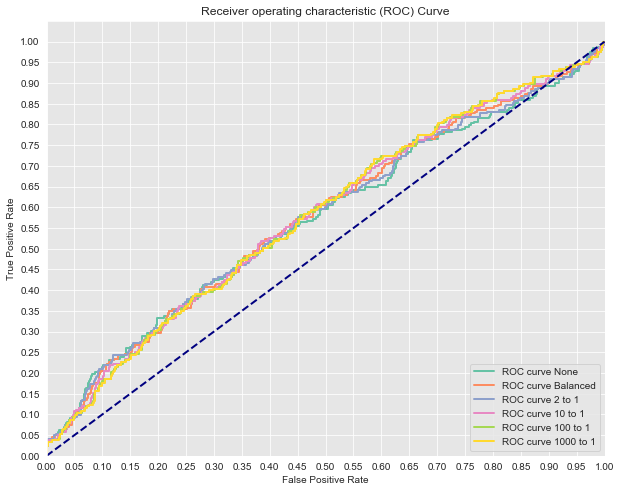

In [272]:
class_imbalance(X_train_all, X_test_all, y_train, y_test)

With a balanced weighted class for both positive examples, there isn't much of a notable increase in AUC score. The best AUC score recorded is 0.579 which comes from varying the class weights 100:1 for positive cases to negative cases.

##### USING SMOTE(SYNTHETIC MINORITY OVERSAMPLING) FOR CLASS IMBALANCE



The next step is to create synthetic examples by randomly sampling feature values of several examples of the minority class(incomplete transactions) and combining them to obtain a new example of that class.

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.1: 0.5706964826461682
-------------------------------------------------------------------------------------
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.25: 0.574174196264012
-------------------------------------------------------------------------------------
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=False,
                   inter

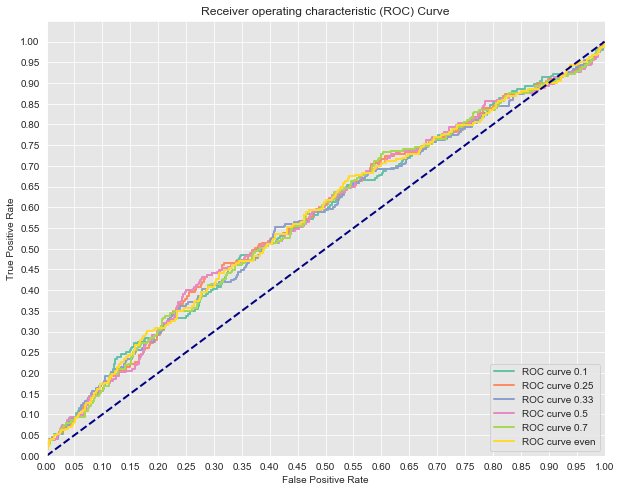

In [274]:
smote_class(X_train_all, X_test_all, y_train, y_test)

The logistic regression model has not performed well on the test data, and the AUC score shows this. With even smote, the AUC score at 0.574 is only slightly better than a random model.
One of the reasons logistic regression has performed below par might be because of the non-linearity of the data which is usually better handled by ensemble algorithms such as random forests or gradient boosted trees classifiers.


**The next step is to tree based classifiers such as Random Forest and gradient boosted trees(XGB)**

#### RANDOM FOREST CLASSIFIER

In [398]:
#fitting a baseline Random Forest Classifier to the data
baseline_forest = RandomForestClassifier(n_estimators =100,max_depth=5)
baseline_forest.fit(X_train_all, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

##### MODEL PERFORMANCE (ACCURACY)

In [399]:
#Training accuracy score and test accuracy score
print("The training accuracy score is :", baseline_forest.score(X_train_all, y_train))
print("The test accuracy score is :", baseline_forest.score(X_test_all, y_test)) #the results below indicates the model is not overfitting

The training accuracy score is : 0.8509333333333333
The test accuracy score is : 0.8408


The Baseline Random forest model outputs a training accuracy of 85.09% and a test accuracy of 84.08%.
This model also generalizes well to the test data. 

##### MODEL PERFORMANCE(ROC-AUC SCORING)

In [400]:
#using cross validation and roc-auc scoring for the baseline random forest model and balanced class weight.
val_forest = RandomForestClassifier(n_estimators =100,max_depth=5, class_weight= "balanced_subsample")
val_forest.fit(X_train_all, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [401]:
print("The training accuracy score is :", val_forest.score(X_train_all, y_train))
print("The test accuracy score is :", val_forest.score(X_test_all, y_test))

The training accuracy score is : 0.8352
The test accuracy score is : 0.7928


In [402]:
# define evaluation procedure for ROC-AUC score
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(val_forest, X_train_all, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.772


The ROC-AUC value is a good improvement on the logistic regression model we achieved earlier.

In [403]:
#Running the model on the test and train data
rf_test = val_forest.predict(X_test_all)
rf_train = val_forest.predict(X_train_all)

In [404]:
cnf_matrix_rf = confusion_matrix(y_test,rf_test)
print('Confusion Matrix for Random Forest Classifier:\n', cnf_matrix_rf)

Confusion Matrix for Random Forest Classifier:
 [[872 135]
 [124 119]]


##### MODEL PERFORMANCE(CONFUSION MATRIX)

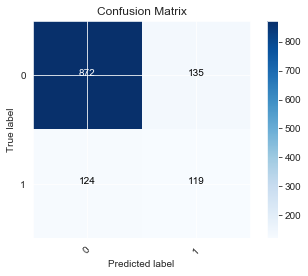

In [406]:
#Plot the confusion matrix
confusion(cnf_matrix_rf, retail_target)

##### MODEL PERFORMANCE(PRECISION,RECALL,ACCURACY,F1-SCORE)

In [596]:
evaluation_metrics(y_train,rf_train,y_test,rf_test)

Training Precision:  0.5920529801324503
Testing Precision:  0.468503937007874


Training Recall:  0.5904887714663144
Testing Recall:  0.4897119341563786


Training Accuracy:  0.8352
Testing Accuracy:  0.7928


Training F1-Score:  0.5912698412698413
Testing F1-Score:  0.47887323943661975


Recall value has certainly improved when compared to the logistic regression model, since we are optimizing the model for a good recall value as we want to predict the most positive cases at the expense of getting more false positives.

##### FEATURE IMPORTANCE FOR RANDOM FOREST CLASSIFIER MODEL

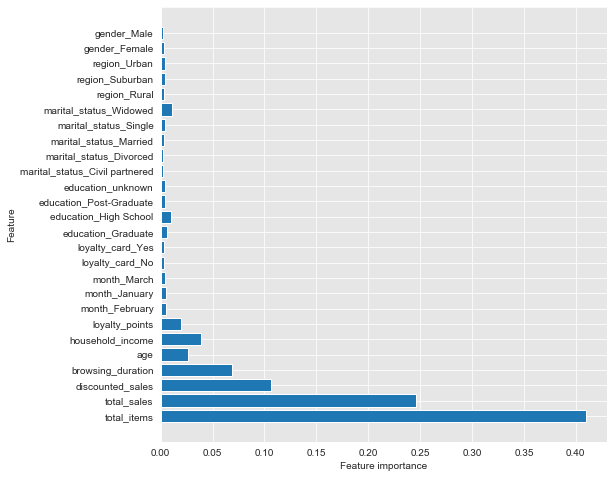

In [408]:
plot_feature_importances(val_forest, X_train_all, X_train_all) #important features driving the random forest model

The top 5 features contributing to model predictions are:
1. total items in the basket
2. total sales of the items
3. discounted sales of the items
4. browsing duration
5. Household income

##### PLOT A DECISION TREE

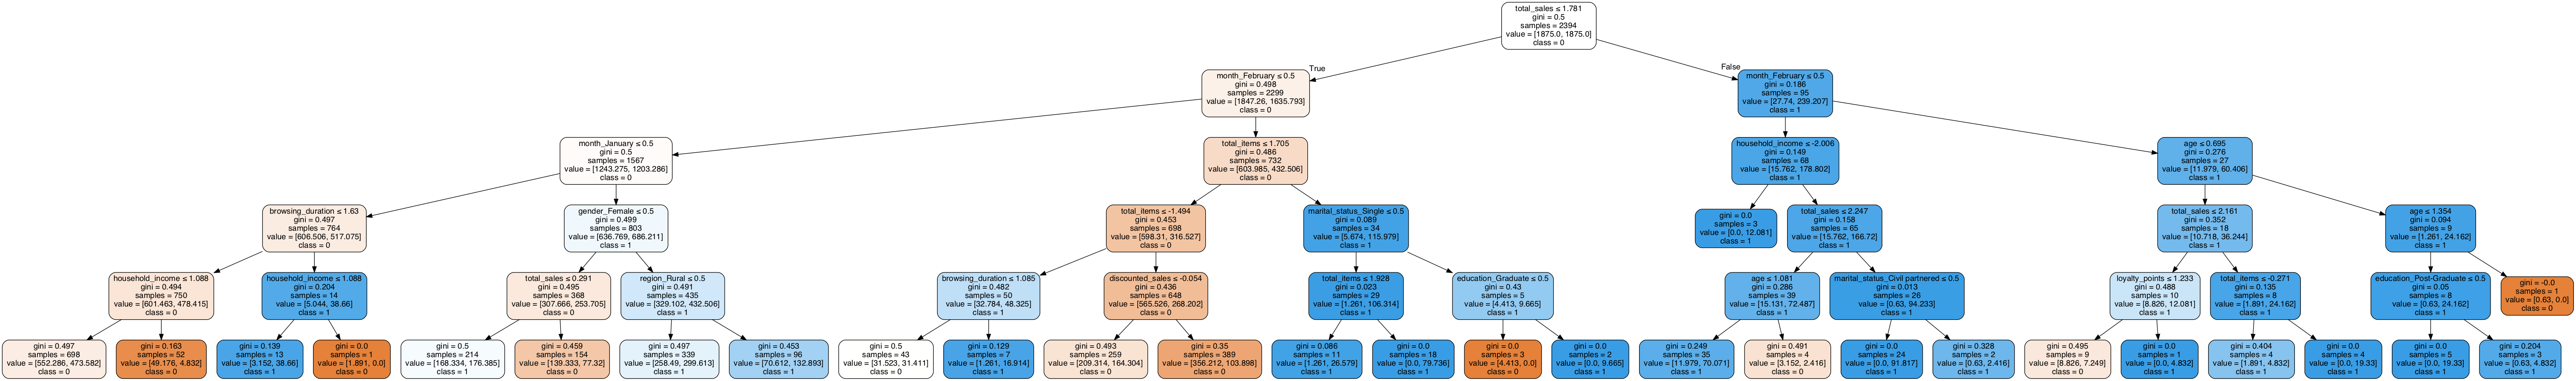

In [330]:
# Create DOT data and plot the decision tree for the first estimator in the forest
dot_data = export_graphviz(val_forest.estimators_[0], out_file=None, 
                           feature_names=X_train_all.columns,  
                           class_names=np.unique(retail_target).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

##### CLASS IMBALANCE USING SMOTE

In [478]:
# Previous original class distribution
print('Original class distribution: \n')
print(y_train.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_all, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

0    2993
1     757
Name: target, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    2993
0    2993
dtype: int64


##### HYPERPARAMTER TUNING OF THE RANDOM FOREST MODEL USING GRID SEARCH,RESAMPLED DATA AND TUNING FOR RECALL

In [410]:
rf_clf = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [10, 30],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [3, 6,10],
    'max_leaf_nodes': [2,4],
    'class_weight' : ['balanced', 'balanced_subsample']
}
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3, scoring ='recall') #optimising for recall
rf_grid_search.fit(X_train_resampled, y_train_resampled)
print(f"Training recall score: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Training recall score: 69.66%

Optimal Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 2, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 10}


In [419]:
rf_score = rf_grid_search.score(X_test_all,y_test)
print('Random forest grid search: ', rf_score)

Random forest grid search:  0.5102880658436214


In [420]:
recall_rf_train = rf_grid_search.predict(X_train_resampled)
recall_rf_test = rf_grid_search.predict(X_test_all)
# Print confusion matrix
cnf_matrix_rf_grid = confusion_matrix(y_test,recall_rf_test)
print('Confusion Matrix for Optimal Random Forest Classifier:\n', cnf_matrix_rf_grid)

Confusion Matrix for Optimal Random Forest Classifier:
 [[696 311]
 [119 124]]


##### CONFUSION MATRIX FOR THE RECALL TUNED MODEL

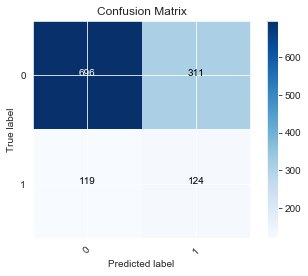

In [422]:
confusion(cnf_matrix_rf_grid, retail_target)

Judging from the confusion matrix above, there is a notable improvement in the number of true positives(incomplete transactions) the model is able to predict compared to the Logistic regression and baseline random forest model as this model is optimised for recall and minority class has been oversampled.

##### DECISION THRESHOLD MOVING FOR RANDOM FOREST MODEL

In [423]:
# this gives the probability [0,1] that each sample belongs to class 1
y_scores = rf_grid_search.predict_proba(X_test_all)[:, 1]

In [424]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t)
    """
    return [1 if y >= t else 0 for y in y_scores]

In [438]:
# generate the precision recall curve
p, r, thresholds = precision_recall_curve(y_test, y_scores)

In [451]:
def precision_recall_threshold(t):
    """
    plots the confusion matrix by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    cnf_matrix = confusion_matrix(y_test,y_pred_adj)
    print('Confusion Matrix for Optimal Random Forest Classifier:\n', cnf_matrix)
    confusion(cnf_matrix, retail_target)

Confusion Matrix for Optimal Random Forest Classifier:
 [[269 738]
 [ 40 203]]


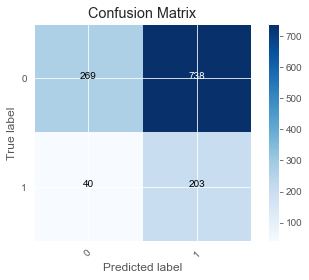

In [455]:
precision_recall_threshold(t = 0.47)

Depending on the cost of false negatives to the business, ajusting the classifier threshold to 0.47 instead of default 0.5 will lead to more true positives = 203 accurately predicted and less false negatives = 40.

##### OPTIMISED RF CLASSIFIER RECALL RATE

In [464]:
y_pred_adj = adjusted_classes(y_scores, t=0.47)
print('Accuracy: ',accuracy_score(y_test, y_pred_adj))
print('Precision: ',precision_score(y_test, y_pred_adj))
print('Recall: ',recall_score(y_test, y_pred_adj))

Accuracy:  0.3776
Precision:  0.2157279489904357
Recall:  0.8353909465020576


Setting the threshold to 0.47, gives a 83.5% recall rate and precision rate of 21.5%. We are able to tune the classifier to detect most of the incomplete transactions whilst still detecting some complete transactions thereby reducing the false positive cases

##### BUILD AND SAVE OPTIMAL RANDOM FOREST CLASSIFIER MODEL

In [533]:
final_rf = RandomForestClassifier(class_weight = 'balanced', criterion ='entropy', max_depth =10, max_leaf_nodes= 2, 
                                  min_samples_leaf = 6, min_samples_split = 5, n_estimators =10)
final_rf.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=2, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [535]:
#save the model
with open('model.pkl','wb') as f:
    pickle.dump(final_rf,f)

In [657]:
#save the standard scaler
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [658]:
#save the one hot encoder
pickle.dump(ohe, open('ohe.pkl', 'wb'))

####  GRADIENT BOOSTED CLASSIFIER WITHOUT RESAMPLED DATA, TUNING FOR ACCURACY

In [475]:
#Run Baseline XGboost classifier model
#Instantiate XGBClassifier
gb_clf = GradientBoostingClassifier(random_state=0)

# Fit XGBClassifier
gb_clf.fit(X_train_all, y_train)

# Predict on training and test sets
train_preds = gb_clf.predict(X_train_all)
test_preds = gb_clf.predict(X_test_all)

# Accuracy of training and test sets
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(train_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 86.93%
Validation accuracy: 83.76%


#####  EVALUATION METRICS(PRECISION,RECALL,ACCURACY,F1-SCORE) FOR XGB MODEL

In [597]:
evaluation_metrics(y_train, train_preds, y_test, test_preds)

Training Precision:  0.8677685950413223
Testing Precision:  0.6818181818181818


Training Recall:  0.41611624834874505
Testing Recall:  0.30864197530864196


Training Accuracy:  0.8693333333333333
Testing Accuracy:  0.8376


Training F1-Score:  0.5625
Testing F1-Score:  0.42492917847025496


The accuracy of the gradient boosted classifier only slightly improved compared to the random forest classifier but the recall score is worse compared to the random forest model.

##### FEATURE IMPORTANCE FOR THE GRADIENT BOOSTED CLASSIFIER

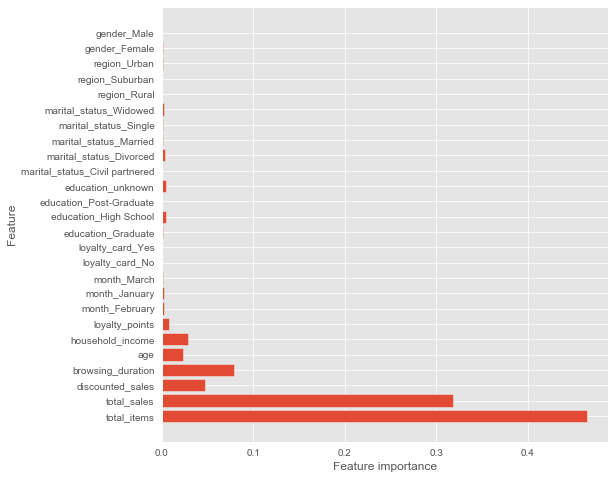

In [477]:
plot_feature_importances(gb_clf, X_train_all, X_train_all) #features driving the gradient boosted model

##### HYPERPARAMETER TUNING FOR THE GB_CLASSIFIER AND TUNING FOR RECALL

In [524]:
param_grid = {
    'loss' : ['exponential'],
    'criterion':['friedman_mse'],
    'learning_rate': [0.1],
    'max_depth': [3],
    'subsample': [0.1,0.3,0.5],
    'n_estimators': [30]
}
gb_grid_clf = GridSearchCV(gb_clf, param_grid, scoring='recall', cv=3, n_jobs=1)
gb_grid_clf.fit(X_train_resampled, y_train_resampled)

best_parameters = gb_grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

gb_train= gb_grid_clf.predict(X_train_resampled)
gb_test = gb_grid_clf.predict(X_test_all)
gb_training_recall = recall_score(y_train_resampled, gb_train)
gb_test_recall = recall_score(y_test, gb_test)

print('')
print('Training Recall: {:.4}%'.format(gb_training_recall * 100))
print('Validation Recall: {:.4}%'.format(gb_test_recall * 100))

Grid Search found the following optimal parameters: 
criterion: 'friedman_mse'
learning_rate: 0.1
loss: 'exponential'
max_depth: 3
n_estimators: 30
subsample: 0.3

Training Recall: 78.52%
Validation Recall: 48.15%


##### EVALUATION METRICS FOR THE GRADIENT BOOSTED CLASSIFIER

In [598]:
evaluation_metrics(y_train_resampled,gb_train,y_test,gb_test)

Training Precision:  0.884789156626506
Testing Precision:  0.48148148148148145


Training Recall:  0.7851653859004344
Testing Recall:  0.48148148148148145


Training Accuracy:  0.8414634146341463
Testing Accuracy:  0.7984


Training F1-Score:  0.8320056647194194
Testing F1-Score:  0.48148148148148145


In [528]:
cnf_matrix_gb = confusion_matrix(y_test,gb_test)
print('Confusion Matrix for Optimal Gradient Boosted Classifier:\n', cnf_matrix_gb)

Confusion Matrix for Optimal Gradient Boosted Classifier:
 [[881 126]
 [126 117]]


The results for the gradient boosted classifier are 117 true positives and 126 false negatives.

##### CONFUSION MATRIX FOR RECALL TUNED GB CLASSIFIER

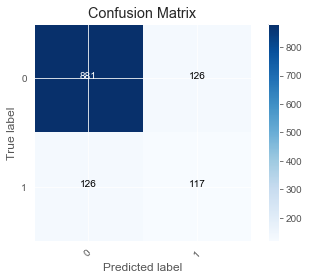

In [530]:
confusion(cnf_matrix_gb, retail_target)

### TEST MODEL ON NEW TRANSACTIONS DATA

The next step is to predict the new transactions data the model has never seen before, we are going to use the random forest classifier.

In [619]:
new_transactions = pd.read_csv("new_transactions.csv")

In [621]:
#rename the transactions column
new_transactions = new_transactions.rename(columns={"Transaction ID": "transaction_id", "Customer ID": "customer_id",
                            "Date": "date", "Total Items": "total_items", "Unique Items": "unique_items",
                            "Total Sales": "total_sales", "Discounted Sales": "discounted_sales",
                            "Browsing Duration (minutes)": "browsing_duration",
                            "Number of Clicks": "number_of_clicks"})

#### MERGE CUSTOMER DATA WITH NEW TRANSACTIONS DATA

In [623]:
new_retail = new_transactions.merge(customers, on = "customer_id")

#### DATA PRE-PROCESSING ON NEW TEST DATA

In [626]:
#feature engineer the education and loyalty points column once more
values = {'education': 'unknown', 'loyalty_points': 0.0}
new_retail = new_retail.fillna(value=values)

In [630]:
#change date to date time object and extract month from datetime feature column.
new_retail['date'] = pd.to_datetime(new_retail['date'])
new_retail['month'] = pd.DatetimeIndex(new_retail['date']).month

In [631]:
#change values in the categorical feature columns month and Loyalty card
dic_1 = {1: 'January', 2: 'February', 3: 'March'}
dic_2 = {0: 'No', 1: 'Yes'}

new_retail.replace({"loyalty_card": dic_2}, inplace = True)

In [632]:
new_retail.replace({'month': dic_1}, inplace = True)

In [634]:
new_retail_cat = new_retail[['month', 'loyalty_card', 'education', 'marital_status', 'region', 'gender']]
new_retail_cont = new_retail[['total_items', 'total_sales', 'discounted_sales',
                     'browsing_duration', 'age', 'household_income', 'loyalty_points']]

In [635]:
#Log normalisations for the distributions of the data
non_normal = ['total_items', 'total_sales', 'discounted_sales',
                     'browsing_duration', 'age', 'household_income', 'loyalty_points']
for feat in non_normal:
    new_retail_cont[feat] = new_retail_cont[feat].map(lambda x: np.log(x + 1))

In [636]:
predictor_scaled = pd.DataFrame(scaler.transform(new_retail_cont), columns = new_retail_cont.columns )

In [637]:
predictor_encoded =ohe.transform(new_retail_cat)

columns = ohe.get_feature_names(input_features=new_retail_cat.columns)
cat_features = pd.DataFrame(predictor_encoded.todense(), columns=columns)

In [638]:
test_data = pd.concat([pd.DataFrame(predictor_scaled), cat_features], axis = 1)

In [639]:
#load the saved model
with open('model.pkl', 'rb') as f:
    classifier = pickle.load(f)

In [647]:
results = (classifier.predict_proba(test_data)[:,1] >= 0.47).astype(bool) # set threshold as 0.47 for a 83.5% recall rate

In [648]:
new_retail['transaction_status'] = pd.Series(results)

In [649]:
new_retail.transaction_status.value_counts(normalize=True)

True     0.624
False    0.376
Name: transaction_status, dtype: float64

##### EXPORT NEW TEST DATA AS CSV

In [651]:
new_retail.to_csv('holland_transactions.csv', encoding='utf-8', index=False)

#### RESULTS OF THE MODEL

62.4% of the new transactions is predicted to be incomplete whilst 37.6% is predicted to be a complete transaction.